## Aula 02 - Exercícios

In [1]:
import pandas as pd
import numpy as np

### Importar base de dados

In [2]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar.gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


### Mapeamento de ids

In [4]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title


### Divisão da base em treino e teste

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)

**Exercício 01**: Considere o modelo SVD++ visto no final da aula de FC - parte 2. Uma das extensões desse modelo em relação ao SVD otimizado é que ele considera a lista de itens que o usuário forneceu feedback implícito (por exemplo, antes de fornecer uma nota a um filme, ele "navegou" por outros filmes, sem dar nota). Podemos simular essa navegação com a base de dados fornecida considerando como feedback implícito de cada usuário o conjunto de itens que ele avaliou, porém descartando as notas.

***a)*** Implemente a função de treinamento do modelo SVD++.

In [ ]:
import math
import numpy as np
import pandas as pd

class SVDPP:
    def __init__(self, n_users, n_items, n_factors=20, lr=0.01, reg=0.02, n_epochs=12, seed=42):
        rng = np.random.default_rng(seed)
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs

        # parâmetros
        self.mu = 0.0
        self.bu = np.zeros(n_users, dtype=np.float32)
        self.bi = np.zeros(n_items, dtype=np.float32)
        self.P = rng.normal(0, 0.01, size=(n_users, n_factors)).astype(np.float32)
        self.Q = rng.normal(0, 0.01, size=(n_items, n_factors)).astype(np.float32)
        self.Y = rng.normal(0, 0.01, size=(n_items, n_factors)).astype(np.float32)  # fatores implícitos

        self.Nu = None  # conjuntos implícitos por usuário

    def _build_implicit_sets(self, df_train: pd.DataFrame):
        Nu = [[] for _ in range(self.n_users)]
        for u, i in zip(df_train['userId'].values, df_train['movieId'].values):
            Nu[int(u)].append(int(i))
        self.Nu = [np.array(v, dtype=np.int64) if len(v) else np.array([], dtype=np.int64) for v in Nu]

    def _implicit_sum(self, u: int):
        Iu = self.Nu[u]
        if Iu.size == 0:
            return np.zeros(self.n_factors, dtype=np.float32), 0.0
        scale = 1.0 / math.sqrt(Iu.size)
        return (scale * self.Y[Iu, :].sum(axis=0)).astype(np.float32), scale

    def predict_single(self, u: int, i: int):
        y_sum, _ = self._implicit_sum(u)
        x = self.P[u] + y_sum
        pred = self.mu + self.bu[u] + self.bi[i] + float(np.dot(self.Q[i], x))
        return float(np.clip(pred, 0.5, 5.0))

    def evaluate_rmse(self, df_eval: pd.DataFrame):
        preds = np.array([self.predict_single(int(u), int(i)) for u, i in zip(df_eval['userId'], df_eval['movieId'])])
        reals = df_eval['rating'].values.astype(np.float32)
        return float(np.sqrt(np.mean((preds - reals) ** 2)))

    def fit(self, df_train: pd.DataFrame, df_valid: pd.DataFrame = None, verbose=True):
        self.mu = float(df_train['rating'].mean())
        self._build_implicit_sets(df_train)

        # agrupar avaliações por usuário
        by_user = [[] for _ in range(self.n_users)]
        for u, i, r in zip(df_train['userId'], df_train['movieId'], df_train['rating']):
            by_user[int(u)].append((int(i), float(r)))

        history = []
        for epoch in range(self.n_epochs):
            for u in range(self.n_users):
                if not by_user[u]:
                    continue
                Iu = np.array([i for (i, _) in by_user[u]], dtype=np.int64)
                y_sum, scale = self._implicit_sum(u)
                pu = self.P[u]
                bu = self.bu[u]

                for (i, rui) in by_user[u]:
                    qi = self.Q[i]
                    bi = self.bi[i]

                    x = pu + y_sum
                    rhat = self.mu + bu + bi + float(np.dot(qi, x))
                    err = rui - rhat

                    self.bu[u] += self.lr * (err - self.reg * bu)
                    self.bi[i] += self.lr * (err - self.reg * bi)

                    qi_old = qi.copy()
                    pu_old = pu.copy()

                    self.Q[i] += self.lr * (err * x - self.reg * qi_old)
                    self.P[u] += self.lr * (err * qi_old - self.reg * pu_old)

                    if Iu.size > 0:
                        self.Y[Iu] += self.lr * ((err * qi_old) * scale - self.reg * self.Y[Iu])

            train_rmse = self.evaluate_rmse(df_train)
            if df_valid is not None and len(df_valid) > 0:
                valid_rmse = self.evaluate_rmse(df_valid)
                history.append((epoch + 1, train_rmse, valid_rmse))
                if verbose:
                    print(f"[Época {epoch+1}] RMSE Treino={train_rmse:.4f} | RMSE Teste={valid_rmse:.4f}")
            else:
                history.append((epoch + 1, train_rmse, np.nan))
        return history

***b)*** Plote a curva de aprendizado de seu modelo.

[Época 1] RMSE Treino=0.8730 | RMSE Teste=0.8878
[Época 2] RMSE Treino=0.8500 | RMSE Teste=0.8718
[Época 3] RMSE Treino=0.8320 | RMSE Teste=0.8597
[Época 4] RMSE Treino=0.8167 | RMSE Teste=0.8502
[Época 5] RMSE Treino=0.8035 | RMSE Teste=0.8430
[Época 6] RMSE Treino=0.7908 | RMSE Teste=0.8372
[Época 7] RMSE Treino=0.7783 | RMSE Teste=0.8323
[Época 8] RMSE Treino=0.7662 | RMSE Teste=0.8286
[Época 9] RMSE Treino=0.7547 | RMSE Teste=0.8259
[Época 10] RMSE Treino=0.7440 | RMSE Teste=0.8240
[Época 11] RMSE Treino=0.7339 | RMSE Teste=0.8228
[Época 12] RMSE Treino=0.7242 | RMSE Teste=0.8221


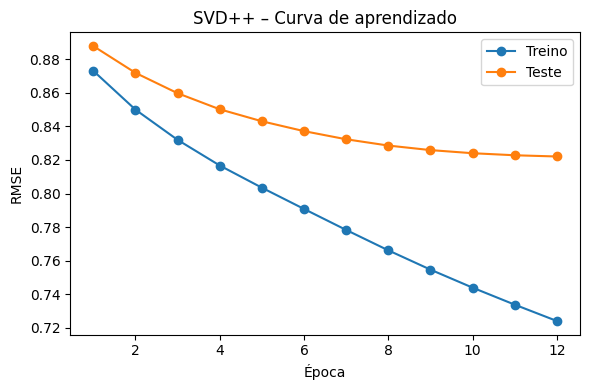

In [17]:
import matplotlib.pyplot as plt

# Instanciando e treinando o modelo
svdpp = SVDPP(n_users, n_items, n_factors=20, lr=0.01, reg=0.02, n_epochs=12, seed=42)
hist = svdpp.fit(train, df_valid=test, verbose=True)

epochs = [h[0] for h in hist]
rmse_tr = [h[1] for h in hist]
rmse_te = [h[2] for h in hist]

plt.figure(figsize=(6,4))
plt.plot(epochs, rmse_tr, marker='o', label='Treino')
plt.plot(epochs, rmse_te, marker='o', label='Teste')
plt.xlabel('Época'); plt.ylabel('RMSE')
plt.title('SVD++ – Curva de aprendizado')
plt.legend()
plt.tight_layout()
plt.show()


***c)*** Implemente a função de predição do modelo SVD++, comparando algumas notas preditas com as notas reais do conjunto de teste.

In [18]:
amostra = test.sample(n=10, random_state=123).copy()
amostra['pred'] = [svdpp.predict_single(int(u), int(i)) for u, i in zip(amostra['userId'], amostra['movieId'])]
amostra['erro_abs'] = (amostra['pred'] - amostra['rating']).abs()
print(amostra[['userId', 'movieId', 'title', 'rating', 'pred', 'erro_abs']])

        userId  movieId                                              title  \
56823     3318       80  Fog of War: Eleven Lessons from the Life of Ro...   
61435     3570       14                                          Go (1999)   
42385     2465       20                     While You Were Sleeping (1995)   
25741     1498      124                              Into the Woods (1991)   
13170      776       91                                Fathers' Day (1997)   
158374    9223       12  Star Wars: Episode V - The Empire Strikes Back...   
47378     2764       55                                   Beethoven (1992)   
43476     2533       34                               Roman Holiday (1953)   
178953   10423      109                        Hot Tub Time Machine (2010)   
158029    9205      165                           Ordet (Word, The) (1955)   

        rating      pred  erro_abs  
56823      4.0  3.950703  0.049297  
61435      4.0  3.443415  0.556585  
42385      2.5  2.516955  0.01

**Exercício 02**: Utilizando o código do NCF visto na aula, compare o desempenho entre as instâncias GMF, MLP e NeuMF nesta base de dados (ml-20m-compact).


=== GMF ===
[Época 1] RMSE Treino=3.1077 | RMSE Teste=3.0990
[Época 2] RMSE Treino=2.9193 | RMSE Teste=2.9200
[Época 3] RMSE Treino=2.1929 | RMSE Teste=2.2147
[Época 4] RMSE Treino=1.3888 | RMSE Teste=1.4374
[Época 5] RMSE Treino=0.9893 | RMSE Teste=1.0479

=== MLP ===
[Época 1] RMSE Treino=0.8655 | RMSE Teste=0.8978
[Época 2] RMSE Treino=0.7946 | RMSE Teste=0.8528
[Época 3] RMSE Treino=0.7915 | RMSE Teste=0.8518
[Época 4] RMSE Treino=0.7904 | RMSE Teste=0.8511
[Época 5] RMSE Treino=0.7892 | RMSE Teste=0.8505

=== NeuMF ===
[Época 1] RMSE Treino=0.8742 | RMSE Teste=0.8990
[Época 2] RMSE Treino=0.7968 | RMSE Teste=0.8513
[Época 3] RMSE Treino=0.7892 | RMSE Teste=0.8485
[Época 4] RMSE Treino=0.7726 | RMSE Teste=0.8442
[Época 5] RMSE Treino=0.7394 | RMSE Teste=0.8364

=== Comparação de desempenho (RMSE Teste) ===
GMF   : 1.0479
MLP   : 0.8505
NeuMF : 0.8364


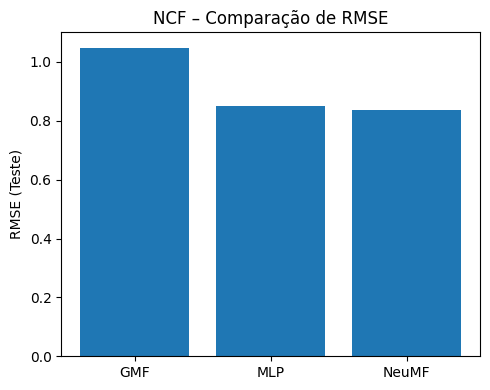

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math

# Dataset PyTorch
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.u = df['userId'].astype(np.int64).values
        self.i = df['movieId'].astype(np.int64).values
        self.r = df['rating'].astype(np.float32).values
    def __len__(self): return len(self.r)
    def __getitem__(self, idx):
        return (torch.tensor(self.u[idx]), torch.tensor(self.i[idx]), torch.tensor(self.r[idx]))

# Modelos GMF, MLP e NeuMF
class GMF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.out = nn.Linear(emb_dim, 1)
    def forward(self, u, i):
        pu, qi = self.user_emb(u), self.item_emb(i)
        return self.out(pu*qi).squeeze(1)

class MLP(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, hidden=(64,32)):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        layers = []
        in_dim = emb_dim*2
        for h in hidden:
            layers += [nn.Linear(in_dim,h), nn.ReLU()]
            in_dim = h
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim,1)
    def forward(self,u,i):
        x = torch.cat([self.user_emb(u), self.item_emb(i)], dim=1)
        return self.out(self.mlp(x)).squeeze(1)

class NeuMF(nn.Module):
    def __init__(self, n_users, n_items, emb_g=16, emb_m=16, hidden=(64,32)):
        super().__init__()
        self.ug, self.ig = nn.Embedding(n_users, emb_g), nn.Embedding(n_items, emb_g)
        self.um, self.im = nn.Embedding(n_users, emb_m), nn.Embedding(n_items, emb_m)
        layers=[]; in_dim=2*emb_m
        for h in hidden: layers+=[nn.Linear(in_dim,h),nn.ReLU()]; in_dim=h
        self.mlp=nn.Sequential(*layers)
        self.out=nn.Linear(emb_g+in_dim,1)
    def forward(self,u,i):
        g=self.ug(u)*self.ig(i)
        m=self.mlp(torch.cat([self.um(u),self.im(i)],dim=1))
        return self.out(torch.cat([g,m],dim=1)).squeeze(1)

# Funções de treino/avaliação
def rmse_model(model, loader, device='cpu'):
    model.eval(); se,n=0,0
    with torch.no_grad():
        for u,i,r in loader:
            u,i,r=u.to(device),i.to(device),r.to(device)
            pred=torch.clamp(model(u,i),0.5,5.0)
            se+=(pred-r).pow(2).sum().item(); n+=len(r)
    return math.sqrt(se/n)

def train_model(model, train_loader, val_loader, epochs=5, device='cpu'):
    opt=torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_fn=nn.MSELoss()
    for ep in range(1,epochs+1):
        model.train()
        for u,i,r in train_loader:
            u,i,r=u.to(device),i.to(device),r.to(device)
            loss=loss_fn(model(u,i),r)
            opt.zero_grad(); loss.backward(); opt.step()
        print(f"[Época {ep}] RMSE treino={rmse_model(model,train_loader,device):.4f} "
              f"| RMSE teste={rmse_model(model,val_loader,device):.4f}")

# Dataloaders
train_loader=DataLoader(RatingsDataset(train),batch_size=2048,shuffle=True)
test_loader=DataLoader(RatingsDataset(test),batch_size=2048)

# Rodar GMF, MLP e NeuMF
device='cuda' if torch.cuda.is_available() else 'cpu'
print("=== GMF ==="); train_model(GMF(n_users,n_items),train_loader,test_loader,epochs=5,device=device)
print("=== MLP ==="); train_model(MLP(n_users,n_items),train_loader,test_loader,epochs=5,device=device)
print("=== NeuMF ==="); train_model(NeuMF(n_users,n_items),train_loader,test_loader,epochs=5,device=device)